In [2]:
import pandas
import numpy
import matplotlib.pyplot as plt
from Bio import SeqIO
import re
import coralme
plt.rcParams['svg.fonttype'] = 'none'
pandas.set_option('display.max_colwidth', None)
%load_ext autoreload
%autoreload 2


In [3]:
# model = coralme.io.json.load_json_me_model("../ACCELERATE/models/pputida-2024_05_20/KT2440-UPF36-DLKcat-Transport10.json")

### Load predictions

In [5]:
# fluxes = pandas.read_csv("./predictions/KT2440-UPF36-DLKcat-Transport10-R2A.csv",index_col=0)
# fluxes = pandas.read_csv("./predictions/KT2440-UPF36-DLKcat-Transport10-M9.csv",index_col=0)
fluxes = pandas.read_csv("./datasets/predictions/KT2440-UPF36-M9.csv",index_col=0)

In [6]:
pred = fluxes[fluxes.index.str.contains("translation_")]["fluxes"]*1e9
pred.name = "predicted"
pred.index = [r.split("translation_")[-1] for r in pred.index]

### Load omics data

In [7]:
rna = pandas.read_csv("./data-jul-2024/RNA-counts.csv",sep=',',index_col=0)[["PPutida_1","PPutida_2","PPutida_4"]]

In [8]:
ribo = pandas.read_csv("./data-jul-2024/RS-counts.csv",sep=',',index_col=0)[["PPutida_1","PPutida_2","PPutida_4"]]

In [9]:
te = ribo.div(rna,axis=0)

In [10]:
samples = rna.columns.to_list()
rna_samples = [i + "_rna" for i in samples]
te_samples = [i + "_te" for i in samples]
all_samples = samples+rna_samples+te_samples+["predicted"]
colors = ["#2b83ba","#66bd63","#fdae61"]

### Load Annotation

In [11]:
Annotation = pandas.read_csv("./GeneAnnotation.csv",index_col=0)

### Combine results

In [12]:
Results = ribo.join(rna,rsuffix="_rna").join(te,rsuffix="_te").join(pred)
ResultsAnnotated = pandas.concat([Results,Annotation],axis=1).loc[Results.index]
ResultsAnnotated.to_csv("ResultsAnnotated.csv")
ResultsAnnotated.head()

,PPutida_1,PPutida_2,PPutida_4,PPutida_1_rna,PPutida_2_rna,PPutida_4_rna,PPutida_1_te,PPutida_2_te,PPutida_4_te,predicted,locus_tag,name,description,type,length,subsystem
PP_0001,4404.0,4187.0,2165.0,64.0,185.0,203.0,68.812500,22.632432,10.665025,NaN,PP_RS00005,NaN,ParB/RepB/Spo0J family partition protein,CDS,873.0,NaN
PP_0010,24817.0,27045.0,10591.0,130.0,329.0,274.0,190.900000,82.203647,38.653285,NaN,PP_RS00050,dnaA,chromosomal replication initiator protein DnaA,CDS,1521.0,NaN
PP_0097,790.0,615.0,401.0,8.0,58.0,47.0,98.750000,10.603448,8.531915,NaN,PP_RS00495,NaN,YheV family putative zinc ribbon protein,CDS,282.0,NaN
PP_0947,1253.0,1395.0,735.0,13.0,21.0,20.0,96.384615,66.428571,36.750000,NaN,PP_RS04975,NaN,ZIP family metal transporter,CDS,894.0,NaN
PP_0948,539.0,585.0,541.0,7.0,16.0,16.0,77.000000,36.562500,33.812500,NaN,PP_RS04980,NaN,HPr family phosphocarrier protein,CDS,273.0,NaN


###  Group by subsystem

In [13]:
ResultsGrouped = ResultsAnnotated[all_samples+["subsystem"]].groupby("subsystem").sum()

In [14]:
ResultsGrouped["predicted"] = ResultsGrouped["predicted"] + 1

### Ribo

In [15]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
from scipy import stats
from scipy.stats import pearsonr

PearsonRResult(statistic=0.7275375327033481, pvalue=3.001075562350641e-46)


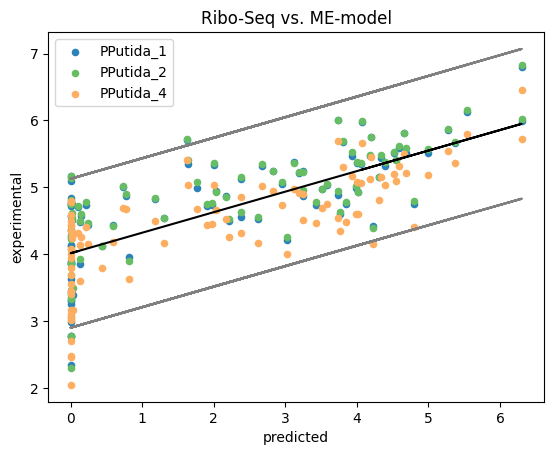

In [16]:
slist = samples
tmp = numpy.log10(ResultsGrouped[slist+["predicted"]]).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
# colors = ["brown","blue","green"]
X = pandas.concat([tmp[["predicted"]],tmp[["predicted"]],tmp[["predicted"]]],axis=1).stack().values
y = tmp[slist].stack().values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
# print(est2.summary())
fig,ax = plt.subplots(1,1)
for idx,s in enumerate(slist):
    tmp.plot.scatter("predicted",s,ax=ax,color=colors[idx],label=s)
plt.plot(X,est2.predict(),color="black")
plt.ylabel("experimental")
print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))


# Confidence interval
st, data, ss2 = summary_table(est2, alpha=0.05)
fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T
plt.plot(X, predict_ci_low, color="gray")
plt.plot(X, predict_ci_upp, color="gray")
plt.title("Ribo-Seq vs. ME-model")



### RNA

PearsonRResult(statistic=0.6817415874692931, pvalue=1.1659432890039311e-38)


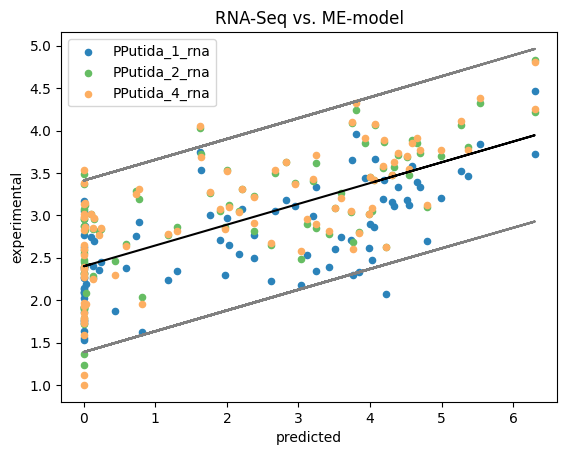

In [17]:
slist = rna_samples
tmp = numpy.log10(ResultsGrouped[slist+["predicted"]]).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
X = pandas.concat([tmp[["predicted"]],tmp[["predicted"]],tmp[["predicted"]]],axis=1).stack().values
y = tmp[slist].stack().values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
# print(est2.summary())
fig,ax = plt.subplots(1,1)
for idx,s in enumerate(slist):
    tmp.plot.scatter("predicted",s,ax=ax,color=colors[idx],label=s)
plt.plot(X,est2.predict(),color="black")
plt.ylabel("experimental")
print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))

# Confidence interval
st, data, ss2 = summary_table(est2, alpha=0.05)
fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T
plt.plot(X, predict_ci_low, color="gray")
plt.plot(X, predict_ci_upp, color="gray")
plt.title("RNA-Seq vs. ME-model")



## TE

PearsonRResult(statistic=0.612718157875608, pvalue=2.845740797555158e-24)


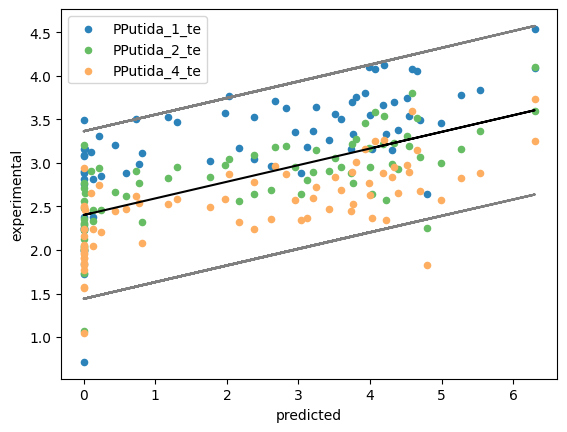

In [18]:
slist = te_samples
tmp = numpy.log10(ResultsGrouped[slist+["predicted"]]).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
X = pandas.concat([tmp[["predicted"]],tmp[["predicted"]],tmp[["predicted"]]],axis=1).stack().values
y = tmp[slist].stack().values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
# print(est2.summary())
fig,ax = plt.subplots(1,1)
for idx,s in enumerate(slist):
    tmp.plot.scatter("predicted",s,ax=ax,color=colors[idx],label=s)
plt.plot(X,est2.predict(),color="black")
plt.ylabel("experimental")
print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))

# Confidence interval
st, data, ss2 = summary_table(est2, alpha=0.05)
fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T
plt.plot(X, predict_ci_low, color="gray")
plt.plot(X, predict_ci_upp, color="gray")



# By sample

### Ribo

PearsonRResult(statistic=0.7503511643020943, pvalue=4.820573260910964e-18)
PearsonRResult(statistic=0.7541172269142817, pvalue=2.6491657232589745e-18)
PearsonRResult(statistic=0.7481060388224295, pvalue=6.853357586484846e-18)


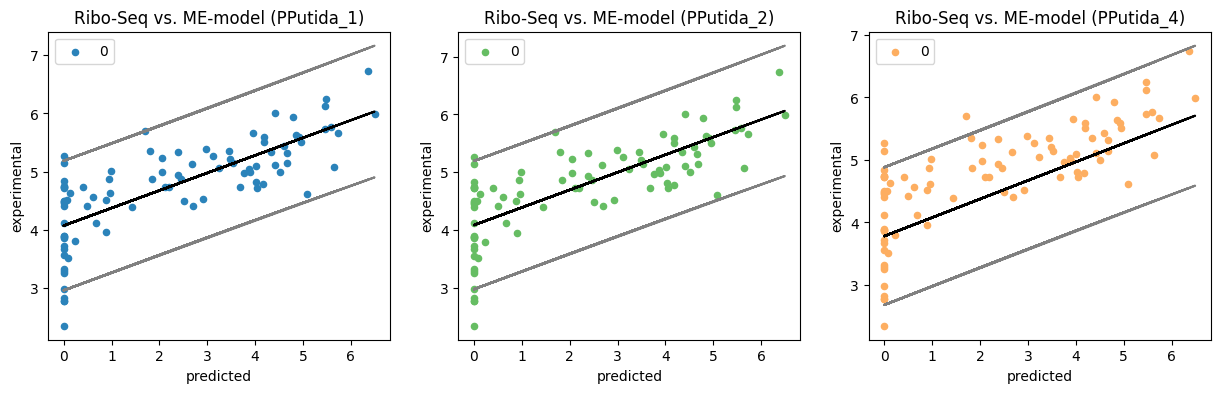

In [34]:
slist = samples
s = 0
fig,ax = plt.subplots(1,3,figsize=(15,4))
for idx,sample in enumerate(samples):
    a = ax[idx]
    tmp = numpy.log10(ResultsGrouped[slist+["predicted"]]).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
    # colors = ["brown","blue","green"]
    X = tmp["predicted"].values
    y = tmp[sample].values
    
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    # print(est2.summary())
    tmp.plot.scatter("predicted",s,ax=a,color=colors[idx],label=s)
    a.plot(X,est2.predict(),color="black")
    a.set_ylabel("experimental")
    print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))
    
    # Confidence interval
    st, data, ss2 = summary_table(est2, alpha=0.05)
    fittedvalues = data[:, 2]
    predict_mean_se  = data[:, 3]
    predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
    predict_ci_low, predict_ci_upp = data[:, 6:8].T
    a.plot(X, predict_ci_low, color="gray")
    a.plot(X, predict_ci_upp, color="gray")
    a.set_title("Ribo-Seq vs. ME-model ({})".format(sample))

### Subsystems

In [197]:
def calculate_score(df,cutoff=100):
    experimental = df[df>cutoff].any(axis=1)
    experimental.name = "experimental"
    predicted = df["predicted"]>1e-16
    results = pandas.concat([experimental,predicted],axis=1)

    TP = results[(results["experimental"] == True) & (results["predicted"] == True)].shape[0]
    TN = results[(results["experimental"] == False) & (results["predicted"] == False)].shape[0]
    FP = results[(results["experimental"] == False) & (results["predicted"] == True)].shape[0]
    FN = results[(results["experimental"] == True) & (results["predicted"] == False)].shape[0]

    T = TP + FN
    N = TN + FP
    
    dct =  {"TP":TP,"TN":TN,"FP":FP,"FN":FN}
    dct["TPR"] = TP/T if T else numpy.nan
    dct["TNR"] = TN/N if N else numpy.nan
    dct["FDR"] = FP/(TP+FP)
    dct["FOR"] = FN/(TN+FN)
    dct["BA"] = (dct["TPR"] + dct["TNR"])/2
    dct["MCC"] = numpy.sqrt(dct["TPR"]*dct["TNR"]*(1-dct["FDR"])*(1-dct["FOR"]))
    return dct,results

In [198]:
ResultsAnnotated.max()

/tmp/ipykernel_53916/590505057.py:1: FutureWarning: The default value of numeric_only in DataFrame.max is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  ResultsAnnotated.max()


PPutida_1                        531119.0
PPutida_2                        747016.0
PPutida_4                        296227.0
PPutida_1_rna                      5402.0
PPutida_2_rna                     14051.0
PPutida_4_rna                     14329.0
PPutida_1_te                          inf
PPutida_2_te                          inf
PPutida_4_te                          inf
predicted                   233630.581047
locus_tag                      PP_RS28865
description      zinc-dependent peptidase
type                                  CDS
length                            26049.0
dtype: object

<Axes: >

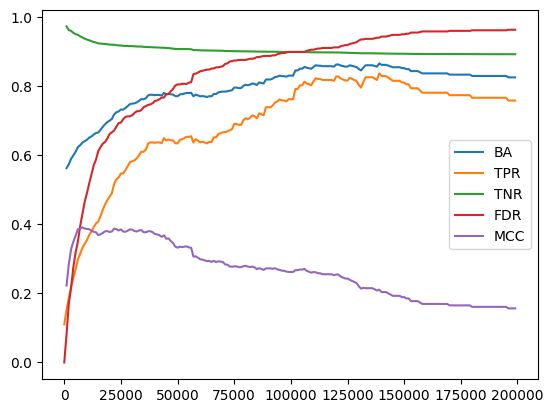

In [199]:
Res = {}
for i in range(0,200000,1000):
    dct,res = calculate_score(ResultsAnnotated[samples+["predicted"]],cutoff=i)
    Res[i] = dct
pandas.DataFrame.from_dict(Res).T[["BA","TPR","TNR","FDR","MCC"]].plot()

<Axes: >

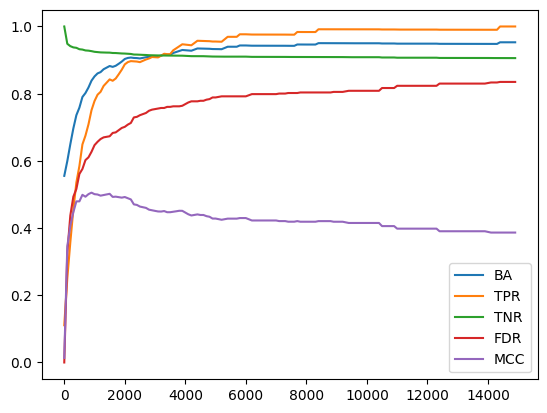

In [182]:
Res = {}
for i in range(0,15000,100):
    dct,res = calculate_score(ResultsAnnotated[rna_samples+["predicted"]],cutoff=i)
    Res[i] = dct
pandas.DataFrame.from_dict(Res).T[["BA","TPR","TNR","FDR","MCC"]].plot()

In [200]:
pandas.DataFrame.from_dict(Res)

,0,1000,2000,3000,4000,5000,6000,7000,8000,9000,...,190000,191000,192000,193000,194000,195000,196000,197000,198000,199000
TP,606.000000,557.000000,503.000000,475.000000,439.000000,413.000000,394.000000,367.000000,346.000000,324.000000,...,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,22.000000,22.000000,22.000000,22.000000
TN,0.000000,1773.000000,2656.000000,3177.000000,3515.000000,3752.000000,3943.000000,4069.000000,4175.000000,4251.000000,...,4863.000000,4863.000000,4863.000000,4863.000000,4863.000000,4863.000000,4863.000000,4863.000000,4863.000000,4863.000000
FP,0.000000,49.000000,103.000000,131.000000,167.000000,193.000000,212.000000,239.000000,260.000000,282.000000,...,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,584.000000,584.000000,584.000000,584.000000
FN,4870.000000,3097.000000,2214.000000,1693.000000,1355.000000,1118.000000,927.000000,801.000000,695.000000,619.000000,...,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
TPR,0.110665,0.152436,0.185131,0.219096,0.244705,0.269758,0.298259,0.314212,0.332373,0.343584,...,0.766667,0.766667,0.766667,0.766667,0.766667,0.766667,0.758621,0.758621,0.758621,0.758621
TNR,NaN,0.973106,0.962668,0.960399,0.954644,0.951077,0.948977,0.944522,0.941375,0.937790,...,0.892949,0.892949,0.892949,0.892949,0.892949,0.892949,0.892785,0.892785,0.892785,0.892785
FDR,0.000000,0.080858,0.169967,0.216172,0.275578,0.318482,0.349835,0.394389,0.429043,0.465347,...,0.962046,0.962046,0.962046,0.962046,0.962046,0.962046,0.963696,0.963696,0.963696,0.963696
FOR,1.000000,0.635934,0.454620,0.347639,0.278234,0.229569,0.190349,0.164476,0.142710,0.127105,...,0.001437,0.001437,0.001437,0.001437,0.001437,0.001437,0.001437,0.001437,0.001437,0.001437
BA,NaN,0.562771,0.573899,0.589747,0.599674,0.610418,0.623618,0.629367,0.636874,0.640687,...,0.829808,0.829808,0.829808,0.829808,0.829808,0.829808,0.825703,0.825703,0.825703,0.825703
MCC,NaN,0.222795,0.284037,0.328018,0.349491,0.367030,0.385998,0.387520,0.391345,0.387781,...,0.161076,0.161076,0.161076,0.161076,0.161076,0.161076,0.156693,0.156693,0.156693,0.156693


In [201]:
dct,res = calculate_score(ResultsAnnotated[samples+["predicted"]],cutoff=1000)
dct

{'TP': 557,
 'TN': 1773,
 'FP': 49,
 'FN': 3097,
 'TPR': 0.15243568691844553,
 'TNR': 0.9731064763995609,
 'FDR': 0.08085808580858085,
 'FOR': 0.6359342915811088,
 'BA': 0.5627710816590032,
 'MCC': 0.22279461019422553}

In [163]:
dct,res = calculate_score(ResultsAnnotated[rna_samples+["predicted"]],cutoff=12000)
dct

{'TP': 107,
 'TN': 4869,
 'FP': 499,
 'FN': 1,
 'TPR': 0.9907407407407407,
 'TNR': 0.9070417287630402,
 'BA': 0.9488912347518905}

In [ ]:
dct = {}
results = {}
for subsystem in ResultsAnnotated["subsystem"].unique():
    df = ResultsAnnotated[ResultsAnnotated["subsystem"].str.contains(subsystem)]
    dct[subsystem],results[subsystem] = calculate_score(df[samples+["predicted"]])
RiboSeqScore = pandas.DataFrame.from_dict(dct).T

In [ ]:
RiboSeqScore

In [ ]:
dct = {}
results = {}
for subsystem in ResultsAnnotated["subsystem"].unique():
    df = ResultsAnnotated[ResultsAnnotated["subsystem"].str.contains(subsystem)]
    dct[subsystem],results[subsystem] = calculate_score(df[rna_samples+["predicted"]])
RNASeqScore = pandas.DataFrame.from_dict(dct).T

In [ ]:
RNASeqScore

In [ ]:
dct,res = calculate_score(ResultsAnnotated[samples+["predicted"]])
dct

In [ ]:
dct,res = calculate_score(ResultsAnnotated[rna_samples+["predicted"]])
dct

In [ ]:
RNASeqScore.sort_values("TP",ascending=False)

In [ ]:
subsystem = "Metabolic:S_Cofactor_and_Prosthetic_Group_Biosynthesis"

In [ ]:
ResultsAnnotated[ResultsAnnotated["subsystem"].str.contains(subsystem)].sort_values("PPutida_1",ascending=False)

In [ ]:
lst = ResultsAnnotated[ResultsAnnotated["subsystem"].str.contains(subsystem)].sort_values("PPutida_1",ascending=False).index

In [ ]:
lst

In [ ]:
ResultsAnnotated[ResultsAnnotated["subsystem"].str.contains(subsystem)].sort_values("predicted",ascending=False)

In [ ]:
ResultsAnnotated[ResultsAnnotated["subsystem"].str.contains("Metabolic:S_Transport__Outer_Membrane")][samples+rna_samples].plot.box(figsize=(10,5))

In [ ]:
tmp = numpy.log10(ResultsGrouped).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
slist = rna_samples
colors = ["brown","blue","green"]
X = pandas.concat([tmp[["predicted"]],tmp[["predicted"]],tmp[["predicted"]]],axis=1).stack().values
y = tmp[slist].stack().values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
fig,ax = plt.subplots(1,1)
for idx,s in enumerate(slist):
    tmp.plot.scatter("predicted",s,ax=ax,color=colors[idx],alpha=0.5)
plt.ylabel("experimental")
plt.plot(X,est2.predict(),color="black")
print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))

In [ ]:
ypred = est2.predict()
yerr = y-ypred
errors = pandas.Series({i:j for i,j in zip(tmp[slist].stack().index,yerr)})
errors.reset_index().set_index("level_0").sort_values(0)